🚀 正在使用的计算设备: cuda
   显卡型号: NVIDIA GeForce RTX 5060 Laptop GPU
   显存总量的: 7.96 GB

📦 正在准备数据...


100%|██████████| 170M/170M [00:45<00:00, 3.71MB/s]   
/home/wangw/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


🏗️ 正在加载 ResNet18 模型...

🔥 开始训练 (共 5 轮)...


Epoch 1/5:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 2/5:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 3/5:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 4/5:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 5/5:   0%|          | 0/391 [00:00<?, ?batch/s]


✅ 训练完成! 总耗时: 35.78 秒
📊 正在绘制结果...


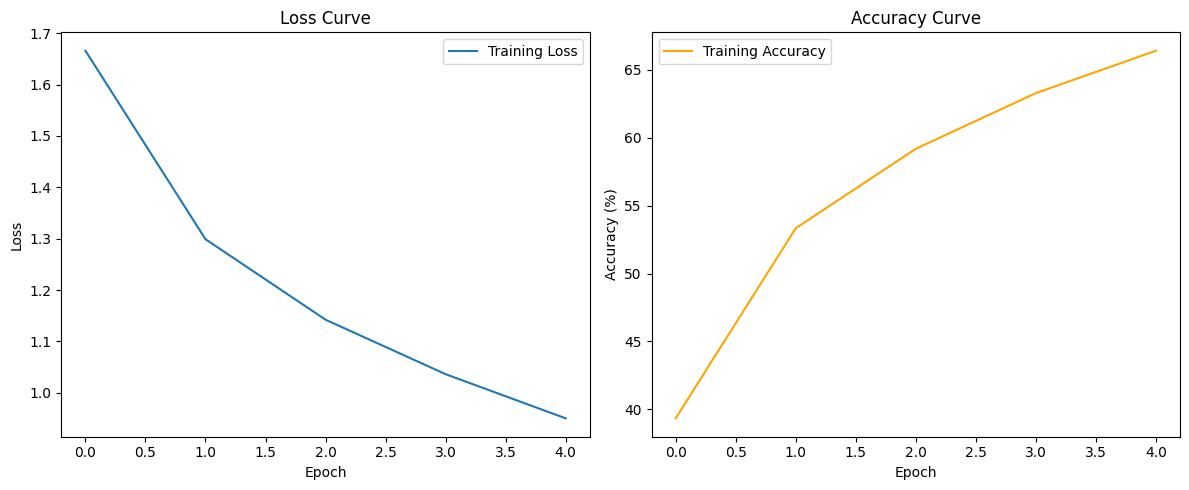

🎉 全部任务结束


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm  # 使用 notebook 专用的进度条，减少卡顿风险
import matplotlib.pyplot as plt
import time
import os

# =================配置区域=================
# 你的 RTX 5060 应该能轻松处理 128 或 256 的 Batch Size
BATCH_SIZE = 128
EPOCHS = 5  # 测试运行 5 轮即可，想跑完整训练可以改成 50
LEARNING_RATE = 0.01
NUM_WORKERS = 2  # WSL2 下建议不要设置太高，2-4 之间为宜
# =========================================

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"🚀 正在使用的计算设备: {device}")
if device.type == 'cuda':
    print(f"   显卡型号: {torch.cuda.get_device_name(0)}")
    print(f"   显存总量的: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# 1. 数据准备 (使用 CIFAR-10)
# 第一次运行会自动下载约 160MB 的数据
print("\n📦 正在准备数据...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 建议将 root 改为你 D 盘的挂载路径，或者直接用相对路径
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# 2. 定义模型 (ResNet18)
print("🏗️ 正在加载 ResNet18 模型...")
# 修改 num_classes=10 适配 CIFAR-10
model = torchvision.models.resnet18(weights=None, num_classes=10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
scaler = torch.amp.GradScaler('cuda') # 混合精度训练，利用 RTX 显卡的 Tensor Cores

# 3. 训练循环
print(f"\n🔥 开始训练 (共 {EPOCHS} 轮)...")
train_losses = []
train_accs = []

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用 tqdm 显示进度条，desc 用于显示当前 Epoch 信息
    pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{EPOCHS}', unit='batch')
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # 开启混合精度上下文
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # 更新进度条后缀，显示实时 Loss 和 Accuracy
        pbar.set_postfix({'Loss': running_loss/(pbar.n+1), 'Acc': 100.*correct/total})

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

end_time = time.time()
print(f"\n✅ 训练完成! 总耗时: {end_time - start_time:.2f} 秒")

# 4. 绘制结果 (测试绘图是否卡顿)
print("📊 正在绘制结果...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print("🎉 全部任务结束")

🚀 正在使用的计算设备: cuda
   显卡型号: NVIDIA GeForce RTX 5060 Laptop GPU
   显存总量的: 7.96 GB

📦 正在准备数据...


/home/wangw/miniconda3/envs/torch_env/lib/python3.11/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


🏗️ 正在加载 ResNet18 模型...

🔥 开始训练 (共 5 轮)...


Epoch 1/5:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 2/5:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 3/5:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 4/5:   0%|          | 0/391 [00:00<?, ?batch/s]

Epoch 5/5:   0%|          | 0/391 [00:00<?, ?batch/s]


✅ 训练完成! 总耗时: 33.80 秒
📊 正在绘制结果...


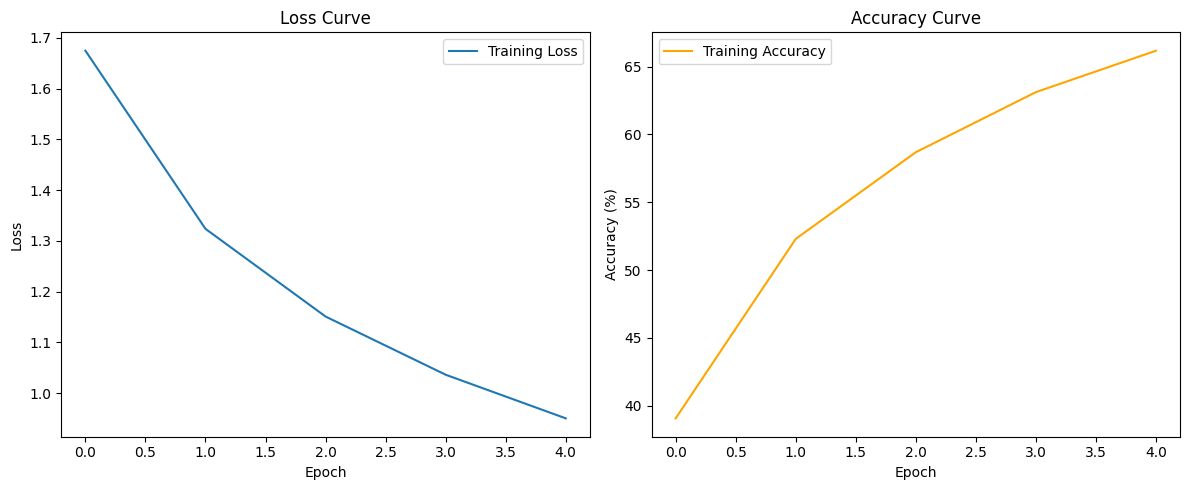

🎉 全部任务结束


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm  # 使用 notebook 专用的进度条，减少卡顿风险
import matplotlib.pyplot as plt
import time
import os

# =================配置区域=================
# 你的 RTX 5060 应该能轻松处理 128 或 256 的 Batch Size
BATCH_SIZE = 128
EPOCHS = 5  # 测试运行 5 轮即可，想跑完整训练可以改成 50
LEARNING_RATE = 0.01
NUM_WORKERS = 2  # WSL2 下建议不要设置太高，2-4 之间为宜
# =========================================

def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"🚀 正在使用的计算设备: {device}")
if device.type == 'cuda':
    print(f"   显卡型号: {torch.cuda.get_device_name(0)}")
    print(f"   显存总量的: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

# 1. 数据准备 (使用 CIFAR-10)
# 第一次运行会自动下载约 160MB 的数据
print("\n📦 正在准备数据...")
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# 建议将 root 改为你 D 盘的挂载路径，或者直接用相对路径
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# 2. 定义模型 (ResNet18)
print("🏗️ 正在加载 ResNet18 模型...")
# 修改 num_classes=10 适配 CIFAR-10
model = torchvision.models.resnet18(weights=None, num_classes=10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
scaler = torch.amp.GradScaler('cuda') # 混合精度训练，利用 RTX 显卡的 Tensor Cores

# 3. 训练循环
print(f"\n🔥 开始训练 (共 {EPOCHS} 轮)...")
train_losses = []
train_accs = []

start_time = time.time()

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用 tqdm 显示进度条，desc 用于显示当前 Epoch 信息
    pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{EPOCHS}', unit='batch')
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # 开启混合精度上下文
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # 更新进度条后缀，显示实时 Loss 和 Accuracy
        pbar.set_postfix({'Loss': running_loss/(pbar.n+1), 'Acc': 100.*correct/total})

    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

end_time = time.time()
print(f"\n✅ 训练完成! 总耗时: {end_time - start_time:.2f} 秒")

# 4. 绘制结果 (测试绘图是否卡顿)
print("📊 正在绘制结果...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

print("🎉 全部任务结束")

In [3]:


# ==========================================
# 🛑 必须放在最前面，防止 PyCharm 远程绘图卡死
import matplotlib
matplotlib.use('Agg') 
# ==========================================

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import time
import os

# ================= ⚙️ 高负载配置区 =================
# 显存压力测试：如果显存报错，请将 BATCH_SIZE 调小 (例如 64)
BATCH_SIZE = 128  
# 计算压力测试：ResNet50 + 64x64分辨率
EPOCHS = 20      
LEARNING_RATE = 0.01
# WSL2 建议设为 2 或 4，设太大可能会导致 CPU 内存交换卡顿
NUM_WORKERS = 4  
# ===================================================

def get_device_info():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"🚀 计算设备: {device}")
    if device.type == 'cuda':
        props = torch.cuda.get_device_properties(0)
        print(f"   显卡型号: {torch.cuda.get_device_name(0)}")
        print(f"   显存总量: {props.total_memory / 1024**3:.2f} GB")
        print(f"   多处理器(SM)数量: {props.multi_processor_count}")
    return device

device = get_device_info()

# 1. 数据准备 (高负载版)
print("\n📦 正在加载并预处理数据 (Resize -> 64x64)...")

# 强行放大图片，增加 GPU 吞吐压力
transform_train = transforms.Compose([
    transforms.Resize(64),  # <--- 关键点：分辨率翻倍，计算量 x4
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# 2. 定义重型模型 (ResNet50)
print("🏗️ 正在加载 ResNet50 模型 (参数量巨大)...")
# 不使用预训练权重，强迫显卡从零计算梯度
model = torchvision.models.resnet50(weights=None, num_classes=10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
scaler = torch.amp.GradScaler('cuda') # 混合精度

# 3. 训练循环
print(f"\n🔥 开始高负载训练 (共 {EPOCHS} 轮)...")
print(f"   预计耗时: 8 ~ 12 分钟")
print("-" * 60)

train_losses = []
train_accs = []
start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 进度条
    pbar = tqdm(trainloader, desc=f'Epoch {epoch+1}/{EPOCHS}', leave=False)
    
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # 混合精度前向传播
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # 反向传播
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # 统计数据
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        # 实时更新进度条后缀
        pbar.set_postfix({'Loss': f"{running_loss/(pbar.n+1):.4f}", 'Acc': f"{100.*correct/total:.2f}%"})

    # Epoch 结束统计
    epoch_duration = time.time() - epoch_start
    epoch_loss = running_loss / len(trainloader)
    epoch_acc = 100. * correct / total
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    
    # 打印该轮简报（避免每一步都打印导致卡顿）
    tqdm.write(f"✅ Epoch {epoch+1} | Time: {epoch_duration:.1f}s | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

total_time = time.time() - start_time
print("-" * 60)
print(f"🏁 训练完成! 总耗时: {total_time/60:.2f} 分钟")

# 4. 保存并绘制结果
print("📊 正在生成结果图表...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='red')
plt.title('Loss Curve (ResNet50)')
plt.xlabel('Epoch')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training Accuracy', color='blue')
plt.title('Accuracy Curve (ResNet50)')
plt.xlabel('Epoch')
plt.grid(True)

save_path = './training_result.png'
plt.savefig(save_path)
print(f"🎉 图表已保存为: {os.path.abspath(save_path)}")
plt.close() # 关闭画布，释放内存

🚀 计算设备: cuda
   显卡型号: NVIDIA GeForce RTX 5060 Laptop GPU
   显存总量: 7.96 GB
   多处理器(SM)数量: 26

📦 正在加载并预处理数据 (Resize -> 64x64)...
🏗️ 正在加载 ResNet50 模型 (参数量巨大)...

🔥 开始高负载训练 (共 20 轮)...
   预计耗时: 8 ~ 12 分钟
------------------------------------------------------------


Epoch 1/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 1 | Time: 26.3s | Loss: 2.1528 | Acc: 31.07%


Epoch 2/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 2 | Time: 24.5s | Loss: 1.4355 | Acc: 49.53%


Epoch 3/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 3 | Time: 25.2s | Loss: 1.2084 | Acc: 57.51%


Epoch 4/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 4 | Time: 25.0s | Loss: 1.0441 | Acc: 63.37%


Epoch 5/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 5 | Time: 26.2s | Loss: 0.9250 | Acc: 67.62%


Epoch 6/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 6 | Time: 24.2s | Loss: 0.8289 | Acc: 71.14%


Epoch 7/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 7 | Time: 25.1s | Loss: 0.7468 | Acc: 74.00%


Epoch 8/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 8 | Time: 25.0s | Loss: 0.6824 | Acc: 76.35%


Epoch 9/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 9 | Time: 25.5s | Loss: 0.6209 | Acc: 78.42%


Epoch 10/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 10 | Time: 24.2s | Loss: 0.5510 | Acc: 80.76%


Epoch 11/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 11 | Time: 25.6s | Loss: 0.5114 | Acc: 82.37%


Epoch 12/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 12 | Time: 25.3s | Loss: 0.4562 | Acc: 84.23%


Epoch 13/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 13 | Time: 25.2s | Loss: 0.4070 | Acc: 85.81%


Epoch 14/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 14 | Time: 24.2s | Loss: 0.3750 | Acc: 87.05%


Epoch 15/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 15 | Time: 25.3s | Loss: 0.3589 | Acc: 87.62%


Epoch 16/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 16 | Time: 25.4s | Loss: 0.3167 | Acc: 89.01%


Epoch 17/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 17 | Time: 25.3s | Loss: 0.2852 | Acc: 90.05%


Epoch 18/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 18 | Time: 23.8s | Loss: 0.2628 | Acc: 90.72%


Epoch 19/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 19 | Time: 25.5s | Loss: 0.2959 | Acc: 89.78%


Epoch 20/20:   0%|          | 0/391 [00:00<?, ?it/s]

✅ Epoch 20 | Time: 26.6s | Loss: 0.2380 | Acc: 91.75%
------------------------------------------------------------
🏁 训练完成! 总耗时: 8.39 分钟
📊 正在生成结果图表...
🎉 图表已保存为: /home/wangw/PycharmProjects/pytorchProject/Zero to Mastery Learn PyTorch for Deep Learning/training_result.png
